<h2 align="center"> Classify spam vs no spam emails</h2>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [1]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [4]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data_Science_Project/Text Classification Using BERT/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2413,spam,I don't know u and u don't know me. Send CHAT ...,1
1563,ham,Dude just saw a parked car with its sunroof po...,0
2048,ham,No de. But call me after some time. Ill tell y...,0
3003,ham,"Excellent, I'll see what riley's plans are",0
5528,ham,Its just the effect of irritation. Just ignore it,0


<h4>Split it into training and test data set</h4>

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [15]:
X_train.head(4)

3433    Camera - You are awarded a SiPix Digital Camer...
4696    URGENT! Your Mobile No 07808726822 was awarded...
5228    PRIVATE! Your 2003 Account Statement for <fone...
3460    Not heard from U4 a while. Call me now am here...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors statements</h4>

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

<h4>Build Model</h4>

In [17]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [19]:
len(X_train)

1120

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [36]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
35/35 [==============================] - 13s 378ms/step - loss: 0.1856 - accuracy: 0.9455 - precision: 0.9385 - recall: 0.9536
Epoch 2/50
35/35 [==============================] - 13s 363ms/step - loss: 0.1916 - accuracy: 0.9455 - precision: 0.9512 - recall: 0.9393
Epoch 3/50
35/35 [==============================] - 13s 362ms/step - loss: 0.1796 - accuracy: 0.9455 - precision: 0.9432 - recall: 0.9482
Epoch 4/50
35/35 [==============================] - 12s 357ms/step - loss: 0.1738 - accuracy: 0.9518 - precision: 0.9567 - recall: 0.9464
Epoch 5/50
35/35 [==============================] - 12s 348ms/step - loss: 0.1726 - accuracy: 0.9545 - precision: 0.9619 - recall: 0.9464
Epoch 6/50
35/35 [==============================] - 12s 338ms/step - loss: 0.1730 - accuracy: 0.9446 - precision: 0.9462 - recall: 0.9429
Epoch 7/50
35/35 [==============================] - 12s 353ms/step - loss: 0.1653 - accuracy: 0.9545 - precision: 0.9619 - recall: 0.9464
Epoch 8/50
35/35 [================

In [37]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 4s 328ms/step - loss: 0.1295 - accuracy: 0.9545 - precision: 0.9474 - recall: 0.9626


[0.1294727772474289,
 0.9545454382896423,
 0.9473684430122375,
 0.9625668525695801]

In [38]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 380ms/step


In [39]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[177,  10],
       [  7, 180]])

Text(50.722222222222214, 0.5, 'Truth')

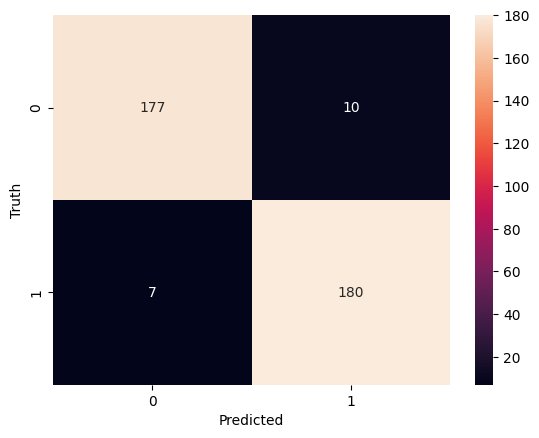

In [41]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       187
           1       0.95      0.96      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



<h4>Inference</h4>

In [43]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.9482296 ],
       [0.9871262 ],
       [0.89967155],
       [0.14031352],
       [0.01371822]], dtype=float32)